In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer

In [4]:
from sklearn.linear_model import LinearRegression, Lasso

In [5]:
from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')

mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716371025351, experiment_id='1', last_update_time=1716371025351, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [9]:
def preprocess_dataframe(df, remove_outliers=True, to_str_features=[]):
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    df_removed_outliers = df
    
    if remove_outliers:
        df_removed_outliers = df[(df.duration >= 1) & (df.duration <= 60)]

    if len(to_str_features) != 0:
        df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)

    return df_removed_outliers

In [10]:
df_jan_23 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [11]:
len(df_jan_23.columns)

19

In [12]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

In [13]:
df_jan_23_removed_outliers = preprocess_dataframe(df_jan_23, to_str_features=categorical)

/tmp/ipykernel_3762/759168457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)


In [14]:
df_jan_23.duration.std()

42.59435124195458

In [15]:
num_samples_total = len(df_jan_23)
num_samples_total

3066766

In [16]:
df_jan_23_removed_outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [17]:
len(df_jan_23_removed_outliers) / num_samples_total

0.9812202822125979

In [18]:
df_jan_23.duration

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3066766, dtype: float64

In [19]:
df_jan_23_removed_outliers.duration.describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

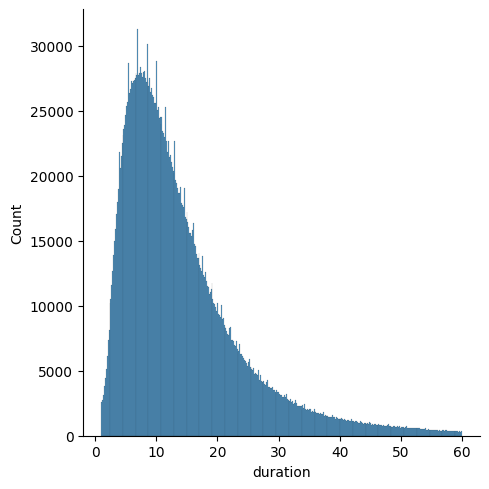

In [20]:
sns.displot(df_jan_23_removed_outliers.duration)

In [21]:
# df_jan_23_removed_outliers[categorical] = df_jan_23_removed_outliers[categorical].astype(str)

In [22]:
df_jan_23_removed_outliers.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [23]:
df_jan_23_removed_outliers[categorical].iloc[0]

PULocationID    161
DOLocationID    141
Name: 0, dtype: object

In [24]:
def fit_features_transform(df, features_names):
    dicts = df[features_names].to_dict(orient='records')
    dv = DictVectorizer()
    dv.fit(dicts)

    return dv

In [25]:
def get_features_target(df, features_names, target_name, features_transform):
    dicts = df[features_names].to_dict(orient='records')
    X = features_transform.transform(dicts)

    y = df[target_name]

    return X, y

In [26]:
# train_dicts = df_jan_23_removed_outliers[categorical + numerical].to_dict(orient='records')

In [27]:
feature_transform = fit_features_transform(df_jan_23_removed_outliers, categorical + numerical)

In [28]:
len(feature_transform.feature_names_) - 1 # one numeric feature

515

In [29]:
X_train, y_train = get_features_target(df_jan_23_removed_outliers, categorical + numerical, target, feature_transform)

In [30]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [31]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [32]:
predictions_train = regressor.predict(X_train)

In [33]:
(((predictions_train - y_train)**2).sum() / len(y_train))**0.5

7.65839726314459

In [34]:
root_mean_squared_error(y_train, predictions_train)

7.65839726314459

In [35]:
sorted(predictions_train)[len(predictions_train)//2]

11.932226860750966

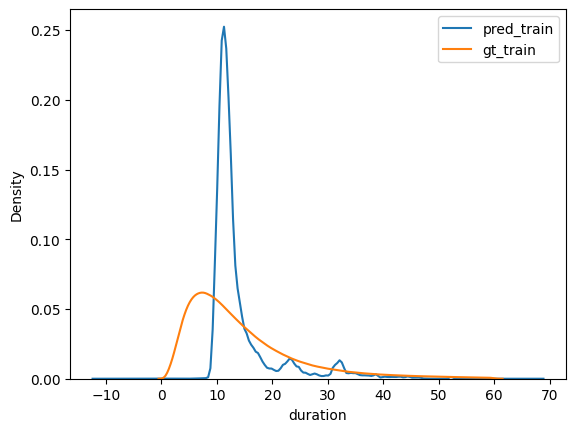

In [36]:
sns.kdeplot(predictions_train, label='pred_train')
sns.kdeplot(y_train, label='gt_train')
plt.legend()

In [37]:
val_df = preprocess_dataframe(pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'), 
                              to_str_features=categorical)

/tmp/ipykernel_3762/759168457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)


In [38]:
X_val, y_val = get_features_target(val_df, categorical + numerical, target, feature_transform)

In [39]:
pred_val = regressor.predict(X_val)

In [40]:
root_mean_squared_error(y_val, pred_val)

7.820259863004852

In [41]:
pred_val

array([11.38015306, 50.6303468 , 15.03454802, ..., 13.56291711,
       11.15134152, 13.1447911 ])

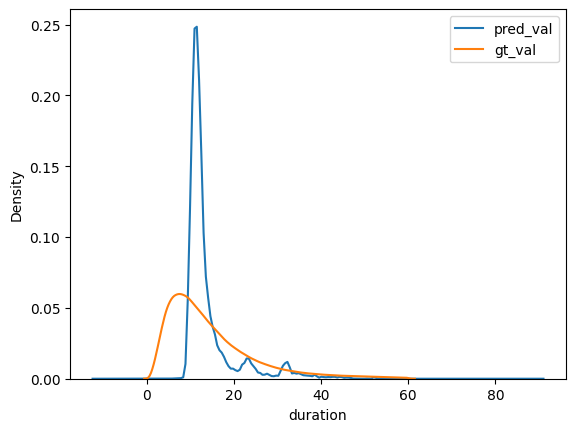

In [42]:
sns.kdeplot(pred_val, label='pred_val')
sns.kdeplot(y_val, label='gt_val')
plt.legend()

In [43]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'aleksandr')
    mlflow.log_param('train-dataset-url', 
                     'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

    mlflow.log_param('val-dataset-url', 
                     'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lasso_reg = Lasso(alpha)

    lasso_reg.fit(X_train, y_train)

    pred_val = lasso_reg.predict(X_val)

    rmse = root_mean_squared_error(y_val, pred_val)
    mlflow.log_metric('rmse', rmse)

In [48]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from functools import partial

In [45]:

def objective(params, train_dataset, val_dataset):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train_dataset,
            num_boost_round=1000,
            evals=[(val_dataset, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(val_dataset)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [46]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [49]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=partial(objective, train_dataset=train, val_dataset=valid),
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-track-env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:32:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.49780                           
[1]	validation-rmse:5.49230                           
[2]	validation-rmse:5.23409                           
[3]	validation-rmse:5.15010                           
[4]	validation-rmse:5.11125                           
[5]	validation-rmse:5.09443                           
[6]	validation-rmse:5.07390                           
[7]	validation-rmse:5.06202                           
[8]	validation-rmse:5.05109                           
[9]	validation-rmse:5.04092                           
[10]	validation-rmse:5.02250                          
[11]	validation-rmse:5.01318                          
[12]	validation-rmse:5.00229                          
[13]	validation-rmse:4.99612                          
[14]	validation-rmse:4.98860                          
[15]	validation-rmse:4.98423                          
[16]	validation-rmse:4.98036                          
[17]	validation-rmse:4.96059                          
[18]	valid

/home/codespace/anaconda3/envs/exp-track-env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:38:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.32531                                                       
[1]	validation-rmse:8.66966                                                       
[2]	validation-rmse:8.09605                                                       
[3]	validation-rmse:7.59623                                                       
[4]	validation-rmse:7.16099                                                       
[5]	validation-rmse:6.78340                                                       
[6]	validation-rmse:6.45753                                                       
[7]	validation-rmse:6.17408                                                       
[8]	validation-rmse:5.93510                                                       
[9]	validation-rmse:5.72753                                                       
[10]	validation-rmse:5.55402                                                      
[11]	validation-rmse:5.40745                                                      
[12]

KeyboardInterrupt: 